## Get embeddings and annonate file

In [17]:
import sys
import pandas as pd
import json, joblib

In [3]:
sys.path.append("..")

In [5]:
dataset_path= "../data/processed/owi/it4i_legal.csv"

df_chunks= pd.read_csv(dataset_path,chunksize=1000)
df1 = next(df_chunks)
df1

,text,url,word_count
0,imprint MaisonOyan Book Now Sitz chemin de Men...,https://maison-oyan.com/en/4340708/imprint,33
1,One moment please Please wait while your reque...,https://calzadosmaja.com/coomeet-evaluate-expe...,11
2,Contact Cine Paris Film Festival Contact Us Ha...,https://cineparisfilmfestival.com/index.php/co...,30
3,Privacy Policy Pangaea Club logo Home Page For...,https://pangaeaclub.net/privacy-policy-2/,397
4,Travel News Asia Search Pages Apple Travel Ind...,https://www.asiatraveltips.com/cgi-bin/search/...,532
...,...,...,...
995,Law of the Lemonade Stand Oregon Legal Researc...,https://blog.oregonlegalresearch.com/law-of-th...,278
996,Desk Partitions For Cubicle Walls Secrete Priv...,https://www.cubicles.com/shop/desk-dividers/de...,311
997,Waiver Consulting Group Support Contact us Ple...,https://help.waivergroup.com/contact-us,21
998,What Makes a Catholic School Catholic weblogo ...,https://www.acsta.ab.ca/news/legal/195-what-ma...,499


In [ ]:
# Load Embedding model
embedding_model_path= '../models/embeddings/tfidf_cf_20_newsgroups.model'
setting = '../models/embeddings/tfidf_cf_20_newsgroups.json'

from src.embeddings.tfidf_cf_embedding import Tf_Idf_Cf_Vectorizer

model = Tf_Idf_Cf_Vectorizer.load_model(embedding_model_path, setting)

Model loaded successfully.


In [14]:
vectorizer=  model.tfidf_vectorizer
cf_weights= model.cf_weights

In [18]:
lr_path = "../models/002_lr__tfidf_cf_20_newsgroups_model.pkl"
lr_model= joblib.load(lr_path)

In [16]:
import numpy as np
from scipy.sparse import csr_matrix

class CFDictPredictor:
    def __init__(self, cf_weights_dict, tfidf_vectorizer, trained_lr_model):
        self.cf_weights = cf_weights_dict["cf_weights"]
        self.tfidf_vectorizer = tfidf_vectorizer
        self.lr_model = trained_lr_model
        self.classes = list(self.cf_weights.keys())  # ["0", "1", "2", ...]
        
    def predict_unlabeled(self, unlabeled_documents, method="predicted_class"):
        """
        Apply CF weighting using your dictionary format
        
        Args:
            method: "predicted_class" or "probabilistic" or "max_cf"
        """
        # Get TF-IDF features
        tfidf_matrix = self.tfidf_vectorizer.transform(unlabeled_documents)
        
        if method == "predicted_class":
            return self._predict_with_hard_assignment(tfidf_matrix, unlabeled_documents)
        elif method == "probabilistic":
            return self._predict_with_probabilistic_weighting(tfidf_matrix, unlabeled_documents)
        elif method == "max_cf":
            return self._predict_with_max_cf(tfidf_matrix, unlabeled_documents)
        else:
            raise ValueError("Method must be 'predicted_class', 'probabilistic', or 'max_cf'")
    
    def _predict_with_hard_assignment(self, tfidf_matrix, documents):
        """Use initial prediction to assign CF weights"""
        # Initial predictions without CF
        initial_predictions = self.lr_model.predict(tfidf_matrix)
        initial_probabilities = self.lr_model.predict_proba(tfidf_matrix)
        
        # Apply CF weighting based on predicted class
        cf_weighted_matrix = self._apply_cf_weighting_hard(tfidf_matrix, initial_predictions)
        
        # Final predictions with CF
        final_predictions = self.lr_model.predict(cf_weighted_matrix)
        final_probabilities = self.lr_model.predict_proba(cf_weighted_matrix)
        
        return {
            'predictions': final_predictions,
            'probabilities': final_probabilities,
            'initial_predictions': initial_predictions,
            'initial_probabilities': initial_probabilities
        }
    
    def _predict_with_probabilistic_weighting(self, tfidf_matrix, documents):
        """Weight CF values by class probabilities"""
        # Get class probabilities
        class_probabilities = self.lr_model.predict_proba(tfidf_matrix)
        
        # Apply probabilistic CF weighting
        cf_weighted_matrix = self._apply_cf_weighting_probabilistic(tfidf_matrix, class_probabilities)
        
        # Final predictions
        final_predictions = self.lr_model.predict(cf_weighted_matrix)
        final_probabilities = self.lr_model.predict_proba(cf_weighted_matrix)
        
        return {
            'predictions': final_predictions,
            'probabilities': final_probabilities,
            'class_probabilities': class_probabilities
        }
    
    def _predict_with_max_cf(self, tfidf_matrix, documents):
        """For each term, use the class with maximum CF value"""
        cf_weighted_matrix = self._apply_max_cf_weighting(tfidf_matrix)
        
        # Final predictions
        final_predictions = self.lr_model.predict(cf_weighted_matrix)
        final_probabilities = self.lr_model.predict_proba(cf_weighted_matrix)
        
        return {
            'predictions': final_predictions,
            'probabilities': final_probabilities
        }
    
    def _apply_cf_weighting_hard(self, tfidf_matrix, predicted_classes):
        """Apply CF weighting using hard class assignment"""
        weighted_matrix = tfidf_matrix.copy()
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
        for doc_idx in range(tfidf_matrix.shape[0]):
            predicted_class = str(predicted_classes[doc_idx])  # Convert to string
            doc_vector = tfidf_matrix[doc_idx]
            
            # Apply CF weights for predicted class
            for term_idx in doc_vector.nonzero()[1]:
                term = feature_names[term_idx]
                
                if predicted_class in self.cf_weights and term in self.cf_weights[predicted_class]:
                    cf_weight = self.cf_weights[predicted_class][term]
                    weighted_matrix[doc_idx, term_idx] *= cf_weight
        
        return weighted_matrix
    
    def _apply_cf_weighting_probabilistic(self, tfidf_matrix, class_probabilities):
        """Apply CF weighting using probability-weighted average"""
        weighted_matrix = tfidf_matrix.copy()
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
        for doc_idx in range(tfidf_matrix.shape[0]):
            doc_vector = tfidf_matrix[doc_idx]
            doc_class_probs = class_probabilities[doc_idx]
            
            for term_idx in doc_vector.nonzero()[1]:
                term = feature_names[term_idx]
                
                # Calculate weighted CF score across all classes
                weighted_cf = 0.0
                total_prob = 0.0
                
                for class_idx, class_name in enumerate(self.classes):
                    if class_name in self.cf_weights and term in self.cf_weights[class_name]:
                        class_prob = doc_class_probs[class_idx]
                        cf_value = self.cf_weights[class_name][term]
                        weighted_cf += class_prob * cf_value
                        total_prob += class_prob
                
                # Apply weighted CF (with fallback to 1.0 if no CF found)
                if total_prob > 0:
                    weighted_matrix[doc_idx, term_idx] *= (weighted_cf / total_prob)
        
        return weighted_matrix
    
    def _apply_max_cf_weighting(self, tfidf_matrix):
        """For each term, use the maximum CF value across all classes"""
        weighted_matrix = tfidf_matrix.copy()
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
        for doc_idx in range(tfidf_matrix.shape[0]):
            doc_vector = tfidf_matrix[doc_idx]
            
            for term_idx in doc_vector.nonzero()[1]:
                term = feature_names[term_idx]
                
                # Find maximum CF value for this term across all classes
                max_cf = 0.0
                for class_name in self.classes:
                    if class_name in self.cf_weights and term in self.cf_weights[class_name]:
                        cf_value = self.cf_weights[class_name][term]
                        max_cf = max(max_cf, cf_value)
                
                # Apply maximum CF weight
                if max_cf > 0:
                    weighted_matrix[doc_idx, term_idx] *= max_cf
        
        return weighted_matrix
    
class EnhancedCFPredictor(CFDictPredictor):
    def __init__(self, cf_weights_dict, tfidf_vectorizer, trained_lr_model):
        super().__init__(cf_weights_dict, tfidf_vectorizer, trained_lr_model)
        
    def predict_with_analysis(self, unlabeled_documents, confidence_threshold=0.8):
        """Predict with detailed analysis of CF impact"""
        
        # Get all three prediction methods
        hard_results = self.predict_unlabeled(unlabeled_documents, method="predicted_class")
        prob_results = self.predict_unlabeled(unlabeled_documents, method="probabilistic")
        max_cf_results = self.predict_unlabeled(unlabeled_documents, method="max_cf")
        
        # Analyze results
        analysis = []
        
        for i, doc in enumerate(unlabeled_documents):
            doc_analysis = {
                'document': doc,
                'hard_prediction': {
                    'class': hard_results['predictions'][i],
                    'confidence': np.max(hard_results['probabilities'][i]),
                    'initial_class': hard_results['initial_predictions'][i],
                    'initial_confidence': np.max(hard_results['initial_probabilities'][i])
                },
                'probabilistic_prediction': {
                    'class': prob_results['predictions'][i],
                    'confidence': np.max(prob_results['probabilities'][i])
                },
                'max_cf_prediction': {
                    'class': max_cf_results['predictions'][i],
                    'confidence': np.max(max_cf_results['probabilities'][i])
                },
                'consensus': None,
                'high_confidence': None
            }
            
            # Check for consensus
            predictions = [
                hard_results['predictions'][i],
                prob_results['predictions'][i],
                max_cf_results['predictions'][i]
            ]
            
            if len(set(predictions)) == 1:
                doc_analysis['consensus'] = predictions[0]
            
            # Check confidence levels
            confidences = [
                np.max(hard_results['probabilities'][i]),
                np.max(prob_results['probabilities'][i]),
                np.max(max_cf_results['probabilities'][i])
            ]
            
            doc_analysis['high_confidence'] = any(conf >= confidence_threshold for conf in confidences)
            doc_analysis['avg_confidence'] = np.mean(confidences)
            
            analysis.append(doc_analysis)
        
        return analysis
    
    def get_term_cf_analysis(self, document, predicted_class=None):
        """Analyze CF weights for terms in a specific document"""
        
        # Get TF-IDF vector for the document
        tfidf_vector = self.tfidf_vectorizer.transform([document])
        feature_names = self.tfidf_vectorizer.get_feature_names_out()
        
        # Get prediction if not provided
        if predicted_class is None:
            predicted_class = str(self.lr_model.predict(tfidf_vector)[0])
        else:
            predicted_class = str(predicted_class)
        
        # Analyze terms
        term_analysis = []
        
        for term_idx in tfidf_vector.nonzero()[1]:
            term = feature_names[term_idx]
            tfidf_score = tfidf_vector[0, term_idx]
            
            term_info = {
                'term': term,
                'tfidf_score': tfidf_score,
                'cf_scores': {},
                'predicted_class_cf': None
            }
            
            # Get CF scores for all classes
            for class_name in self.classes:
                if class_name in self.cf_weights and term in self.cf_weights[class_name]:
                    term_info['cf_scores'][class_name] = self.cf_weights[class_name][term]
            
            # Get CF for predicted class
            if predicted_class in term_info['cf_scores']:
                term_info['predicted_class_cf'] = term_info['cf_scores'][predicted_class]
                term_info['final_score'] = tfidf_score * term_info['predicted_class_cf']
            else:
                term_info['final_score'] = tfidf_score
            
            term_analysis.append(term_info)
        
        # Sort by final score (TF-IDF * CF)
        term_analysis.sort(key=lambda x: x['final_score'], reverse=True)
        
        return term_analysis

In [20]:
# Initialize predictor
predictor = EnhancedCFPredictor(
    cf_weights_dict=cf_weights,
    tfidf_vectorizer=vectorizer,  # Your trained TF-IDF vectorizer
    trained_lr_model=lr_model           # Your trained LR model
)

# Unlabeled documents
unlabeled_documents = [
    "machine learning classification algorithms",
    "deep neural network architecture",
    "natural language processing techniques"
]

# Method 1: Compare all prediction methods
print("=== Comprehensive Analysis ===")
analysis = predictor.predict_with_analysis(unlabeled_documents, confidence_threshold=0.8)

for i, doc_analysis in enumerate(analysis):
    print(f"\nDocument {i}: {doc_analysis['document']}")
    print(f"Hard Assignment: Class {doc_analysis['hard_prediction']['class']} "
          f"(conf: {doc_analysis['hard_prediction']['confidence']:.3f})")
    print(f"Probabilistic:   Class {doc_analysis['probabilistic_prediction']['class']} "
          f"(conf: {doc_analysis['probabilistic_prediction']['confidence']:.3f})")
    print(f"Max CF:          Class {doc_analysis['max_cf_prediction']['class']} "
          f"(conf: {doc_analysis['max_cf_prediction']['confidence']:.3f})")
    
    if doc_analysis['consensus']:
        print(f"✓ CONSENSUS: Class {doc_analysis['consensus']}")
    else:
        print("⚠ NO CONSENSUS")
    
    print(f"High Confidence: {doc_analysis['high_confidence']}")
    print(f"Avg Confidence: {doc_analysis['avg_confidence']:.3f}")

# Method 2: Detailed term analysis
print("\n=== Term-Level CF Analysis ===")
for i, doc in enumerate(unlabeled_documents):
    print(f"\nDocument {i}: {doc}")
    term_analysis = predictor.get_term_cf_analysis(doc)
    
    print("Top terms by TF-IDF * CF:")
    for term_info in term_analysis[:5]:  # Top 5 terms
        print(f"  {term_info['term']}: "
              f"TF-IDF={term_info['tfidf_score']:.4f}, "
              f"CF={term_info['predicted_class_cf'] or 'N/A'}, "
              f"Final={term_info['final_score']:.4f}")

# Method 3: Simple prediction with specific method
print("\n=== Simple Prediction ===")
simple_predictor = CFDictPredictor(cf_weights, vectorizer, lr_model)
results = simple_predictor.predict_unlabeled(unlabeled_documents, method="probabilistic")

for i, (pred, prob) in enumerate(zip(results['predictions'], results['probabilities'])):
    print(f"Document {i}: Class {pred} (confidence: {np.max(prob):.3f})")

=== Comprehensive Analysis ===

Document 0: machine learning classification algorithms
Hard Assignment: Class 13 (conf: 1.000)
Probabilistic:   Class 13 (conf: 1.000)
Max CF:          Class 13 (conf: 1.000)
✓ CONSENSUS: Class 13
High Confidence: True
Avg Confidence: 1.000

Document 1: deep neural network architecture
Hard Assignment: Class 17 (conf: 1.000)
Probabilistic:   Class 17 (conf: 1.000)
Max CF:          Class 17 (conf: 1.000)
✓ CONSENSUS: Class 17
High Confidence: True
Avg Confidence: 1.000

Document 2: natural language processing techniques
Hard Assignment: Class 1 (conf: 0.999)
Probabilistic:   Class 1 (conf: 0.999)
Max CF:          Class 1 (conf: 0.999)
✓ CONSENSUS: Class 1
High Confidence: True
Avg Confidence: 0.999

=== Term-Level CF Analysis ===

Document 0: machine learning classification algorithms
Top terms by TF-IDF * CF:
  classification: TF-IDF=0.6302, CF=N/A, Final=0.6302
  algorithms: TF-IDF=0.4984, CF=N/A, Final=0.4984
  learning: TF-IDF=0.4825, CF=N/A, Final=0.

In [21]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

# Set file paths
dataset_path = "../data/processed/owi/it4i_legal.csv"
output_path = "../data/processed/owi/it4i_legal_annotated.csv"

# Initialize predictor
predictor = EnhancedCFPredictor(cf_weights, vectorizer, lr_model)

# Check if output file already exists
first_chunk = True if not os.path.exists(output_path) else False

# Create a CSV writer with headers on first write
with pd.read_csv(dataset_path, chunksize=1000) as reader:
    for chunk_idx, df_chunk in enumerate(tqdm(reader, desc="Processing Chunks")):
        if 'text' not in df_chunk.columns:
            raise ValueError("The input CSV must contain a 'text' column.")

        texts = df_chunk['text'].fillna("").tolist()

        # Perform predictions
        analysis = predictor.predict_with_analysis(texts, confidence_threshold=0.8)

        # Extract results
        results = []
        for i, row in enumerate(analysis):
            results.append({
                'text': row['document'],
                'predicted_class_hard': row['hard_prediction']['class'],
                'confidence_hard': row['hard_prediction']['confidence'],
                'initial_class': row['hard_prediction']['initial_class'],
                'initial_confidence': row['hard_prediction']['initial_confidence'],
                'predicted_class_prob': row['probabilistic_prediction']['class'],
                'confidence_prob': row['probabilistic_prediction']['confidence'],
                'predicted_class_maxcf': row['max_cf_prediction']['class'],
                'confidence_maxcf': row['max_cf_prediction']['confidence'],
                'consensus': row['consensus'],
                'high_confidence': row['high_confidence'],
                'avg_confidence': row['avg_confidence']
            })

        # Create DataFrame from results
        annotated_chunk = pd.DataFrame(results)

        # Append to CSV
        annotated_chunk.to_csv(output_path, mode='a', header=first_chunk, index=False)
        first_chunk = False  # Only write header for first chunk

Processing Chunks: 540it [19:55,  2.21s/it]


In [6]:
import pandas as pd
output_path = "../data/processed/owi/it4i_legal_annotated.csv"

dfchunks = pd.read_csv(output_path,chunksize=10000)
df_out = next(dfchunks)


In [4]:
df_out.to_csv("../data/processed/owi/it4i_legal_annotated_small.csv", index=False,quoting=1)

In [9]:
df_out = next(dfchunks)
df_out.to_csv("../data/processed/owi/it4i_legal_annotated_small_test.csv", index=False,quoting=1)

/var/folders/3f/6g751cj549sbdzh4d8njjpx80000gn/T/ipykernel_36303/624898647.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


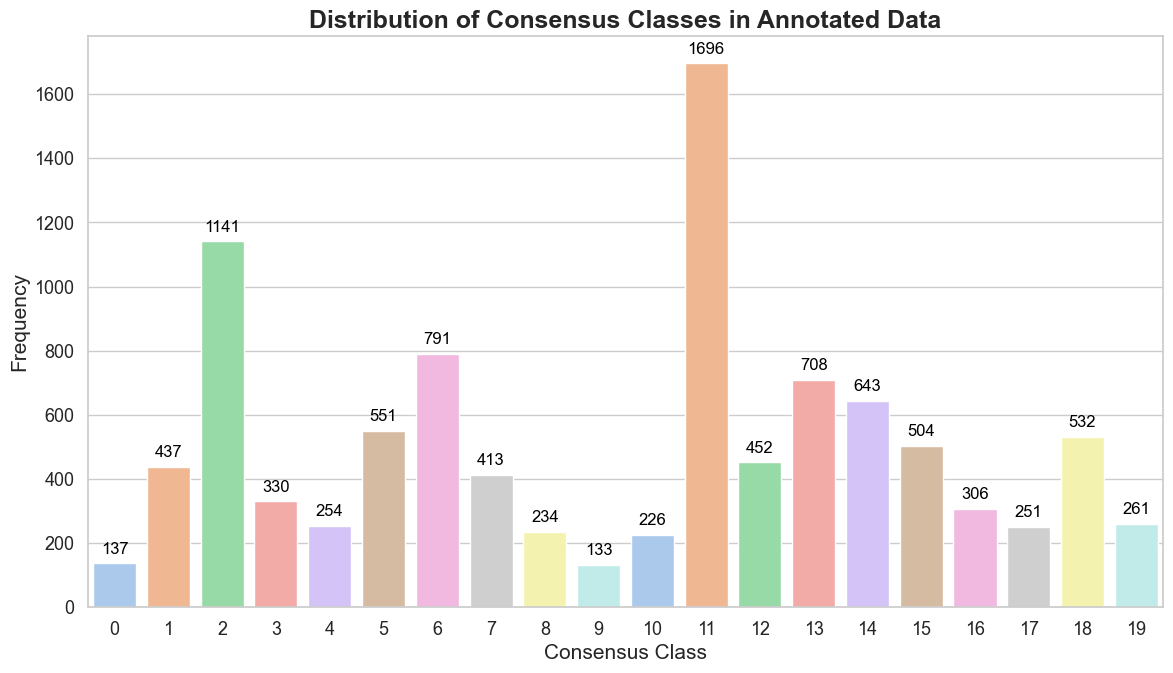

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.3, palette="pastel")

# Countplot for discrete consensus classes
ax = sns.countplot(
    x="label",
    data=df_out,
    palette="pastel",
    order=sorted(df_out['label'].unique())
)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=12, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

plt.xlabel('Consensus Class', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of Consensus Classes in Annotated Data', fontsize=18, weight='bold')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()